## Pre-init

In [112]:
# !pip install -q statsmodels
# !pip install -q xlrd
# !pip install -q Cython
# !pip install -q prophet


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import warnings

In [4]:
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [5]:
df = pd.read_excel("Superstore_dataset.xls")
furniture = df.loc[df['Category'] == 'Furniture']

## Data Preprocessing

In [6]:
furniture.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136


In [7]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis = 1, inplace = True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [8]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [9]:
furniture.head(1)

,Order Date,Sales
0,2014-01-06,2573.82


In [10]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [11]:
y = furniture['Sales'].resample('MS').mean()
y['2015']

Order Date
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
Freq: MS, Name: Sales, dtype: float64

### Visualizing Furniture Sales Time Series Data

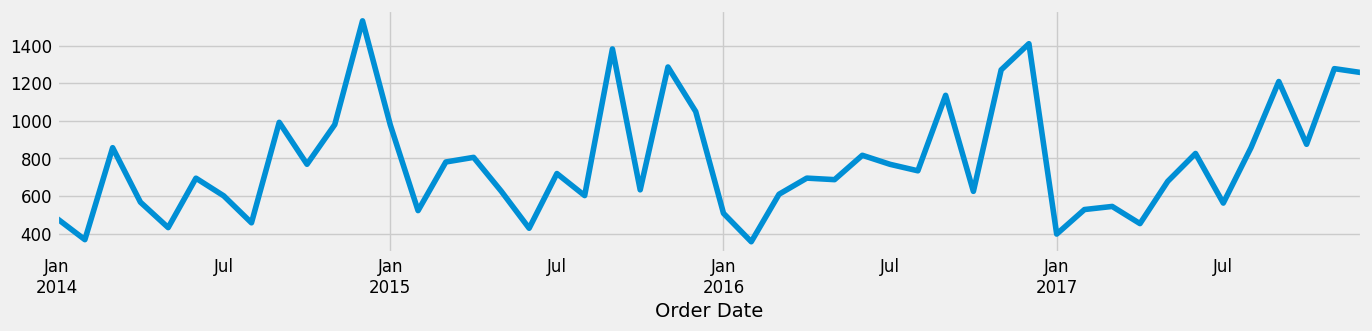

In [12]:
y.plot(figsize=(15, 3))
plt.show()

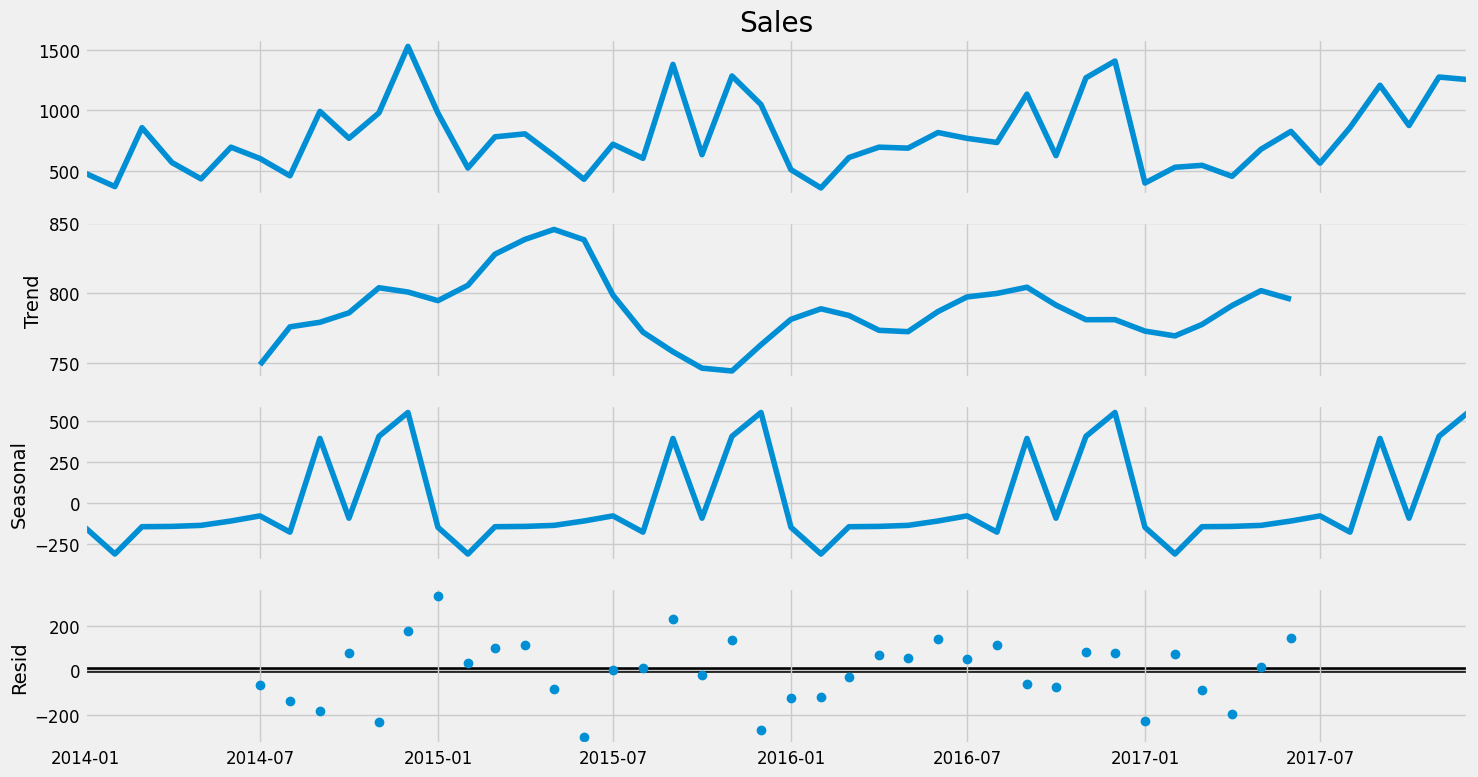

In [13]:
# time-series decomposition
from pylab import rcParams

rcParams['figure.figsize'] = 15, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')

fig = decomposition.plot()
plt.show()

In [14]:
# ARIMA - Autoregressive Integrated Moving Average
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1457.5412534942598
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919703
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997935736
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1179.6903776415356
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803033336
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2621.5327370301484
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091517
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732915
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.5634719720483
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2556.28914808803
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946868
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576454926
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668259312
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1295.1066017507496
ARI

In [16]:
# Fitting the ARIMA model, based on the lowest ARIMA suggestion we got
mod = sm.tsa.statespace.SARIMAX(y, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0853      0.250      0.342      0.733      -0.404       0.575
ma.L1         -0.9984     14.062     -0.071      0.943     -28.560      26.563
ar.S.L12       0.0274      0.588      0.047      0.963      -1.124       1.179
ma.S.L12      -0.9918     61.475     -0.016      0.987    -121.481     119.498
sigma2      2.741e+04   1.79e+06      0.015      0.988   -3.47e+06    3.53e+06


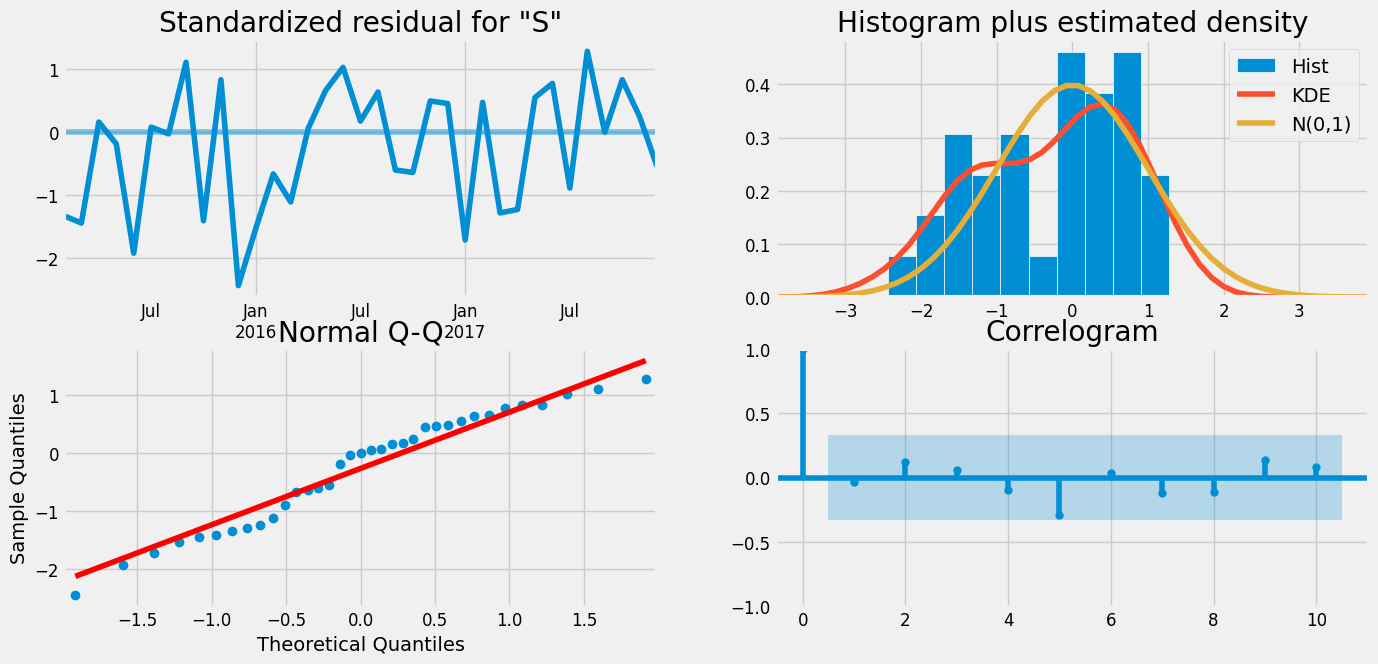

In [17]:
results.plot_diagnostics(figsize = (15, 7))
plt.show()

In [73]:
# Validating forecasts
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

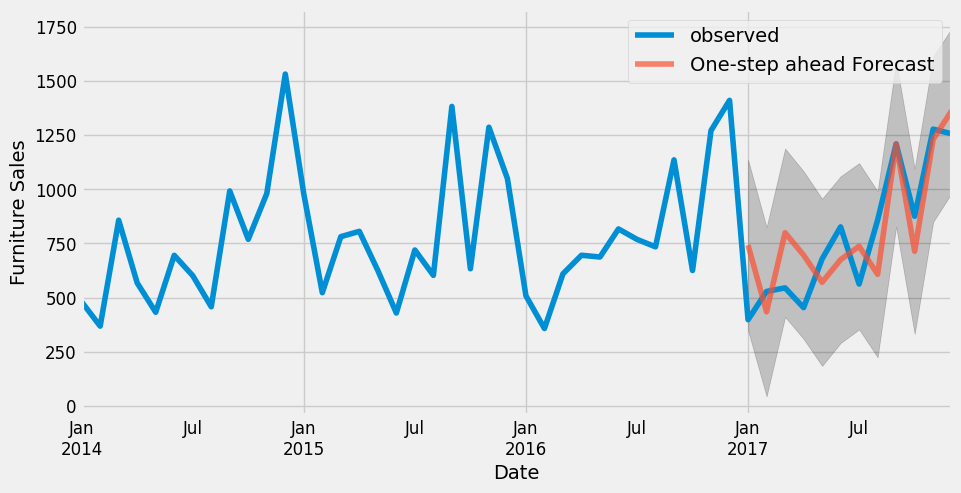

In [74]:
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

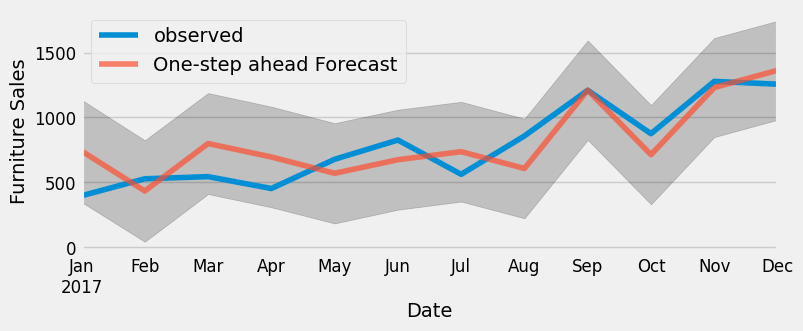

In [75]:
limited_y = y['2017':]
ax = limited_y.plot(label='observed')
limited_pred_ci = pred_ci['2017':]
pred.predicted_mean['2017':].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(8, 3))
ax.fill_between(limited_pred_ci.index,
                limited_pred_ci.iloc[:, 0],
                limited_pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [78]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of the forecasts is: {}'.format(round(mse, 2)))

The Mean Squared Error of the forecasts is: 34903.22


In [79]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 186.82


In [80]:
# Producing and visualizing forecasts
pred_uc = results.get_forecast(steps = 100)
pred_ci = pred_uc.conf_int()

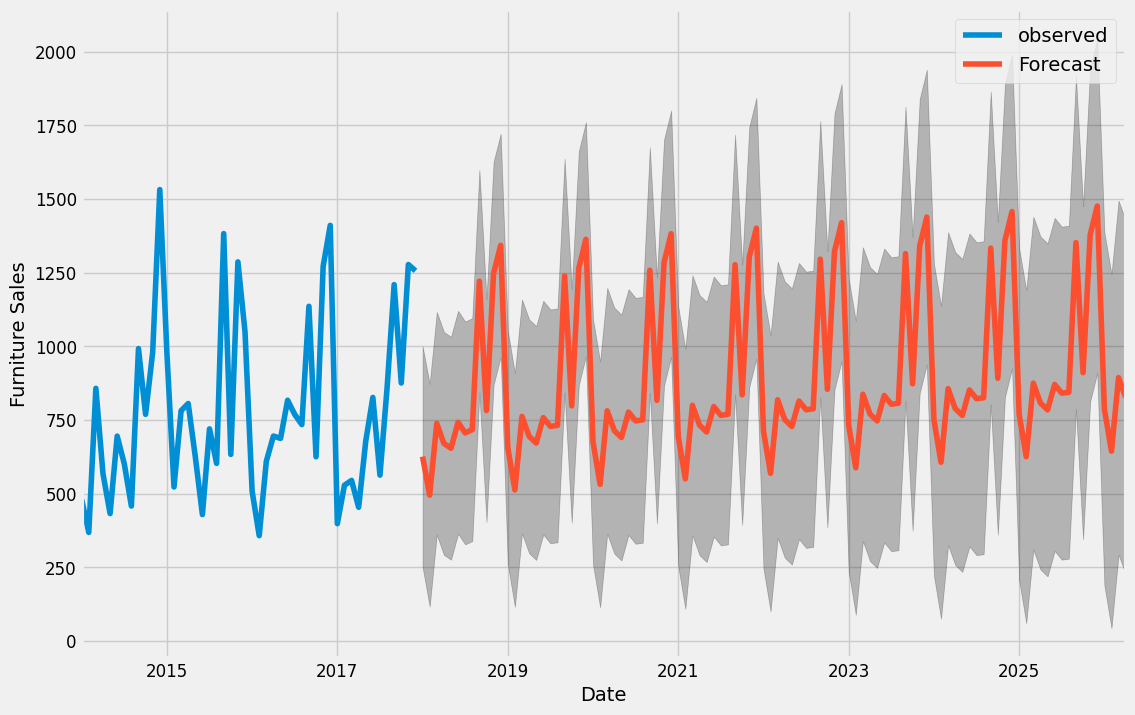

In [83]:
ax = y.plot(label='observed', figsize=(12, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

### Time Series of Furniture vs. Office Supplies

In [84]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

#### Data Exploration

In [85]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

furniture.drop(cols, axis = 1, inplace = True)
office.drop(cols, axis = 1, inplace = True)

In [86]:
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

In [87]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [88]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

In [89]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

In [90]:
furniture = pd.DataFrame({'Order Date': y_furniture.index, 'Sales': y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

In [91]:
store = furniture.merge(office, how = 'inner', on = 'Order Date')
store.rename(columns = {'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace = True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


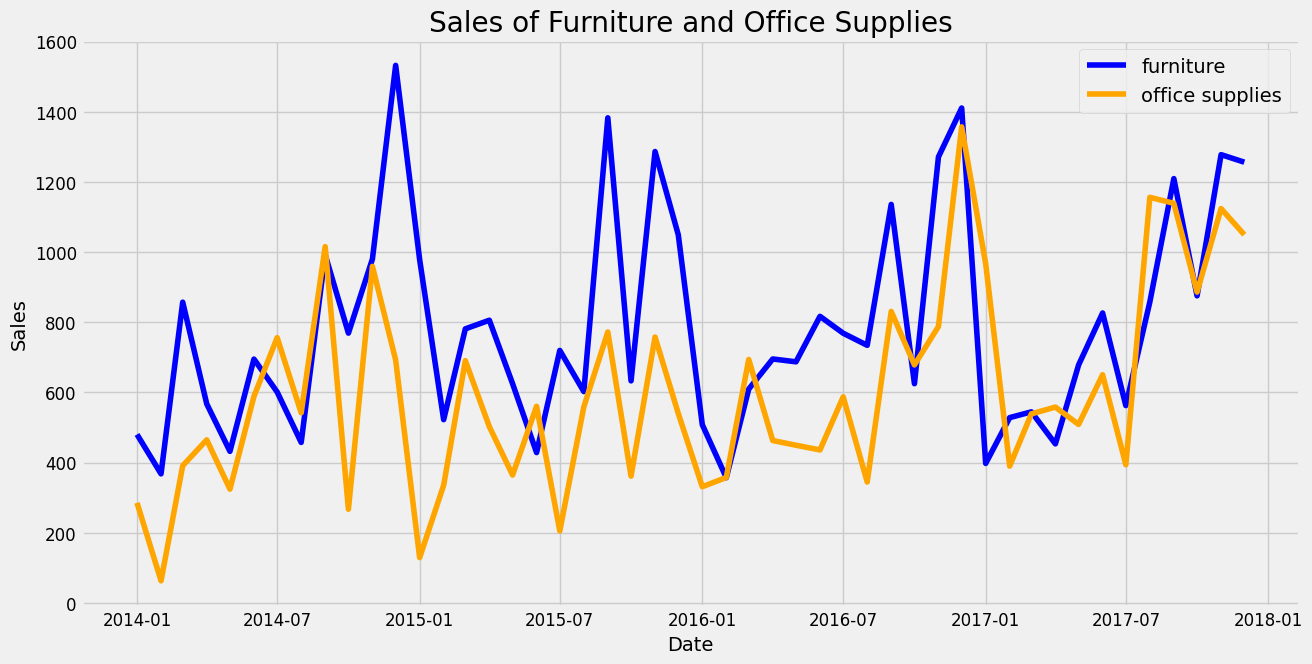

In [104]:
plt.figure(figsize = (14, 7))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'orange', label = 'office supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of Furniture and Office Supplies')
plt.legend()

In [107]:
first_date = store.loc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']
print("Office supplies first time produced higher sales than furniture is at: {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is at: 2014-07-01.


## Time Series Modeling with Prophet

https://facebook.github.io/prophet/

In [113]:
from prophet import Prophet

In [114]:
furniture = furniture.rename(columns = {'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width = 0.95)
furniture_model.fit(furniture)

15:47:54 - cmdstanpy - INFO - Chain [1] start processing
15:47:55 - cmdstanpy - INFO - Chain [1] done processing


In [115]:
office = office.rename(columns = {'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width = 0.95)
office_model.fit(office)

15:48:01 - cmdstanpy - INFO - Chain [1] start processing
15:48:01 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
furniture_forecast = furniture_model.make_future_dataframe(periods = 36, freq = 'MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

In [117]:
office_forecast = office_model.make_future_dataframe(periods = 36, freq = 'MS')
office_forecast = office_model.predict(office_forecast)

Text(0.5, 1.0, 'Furniture Sales')

<Figure size 1500x1000 with 0 Axes>

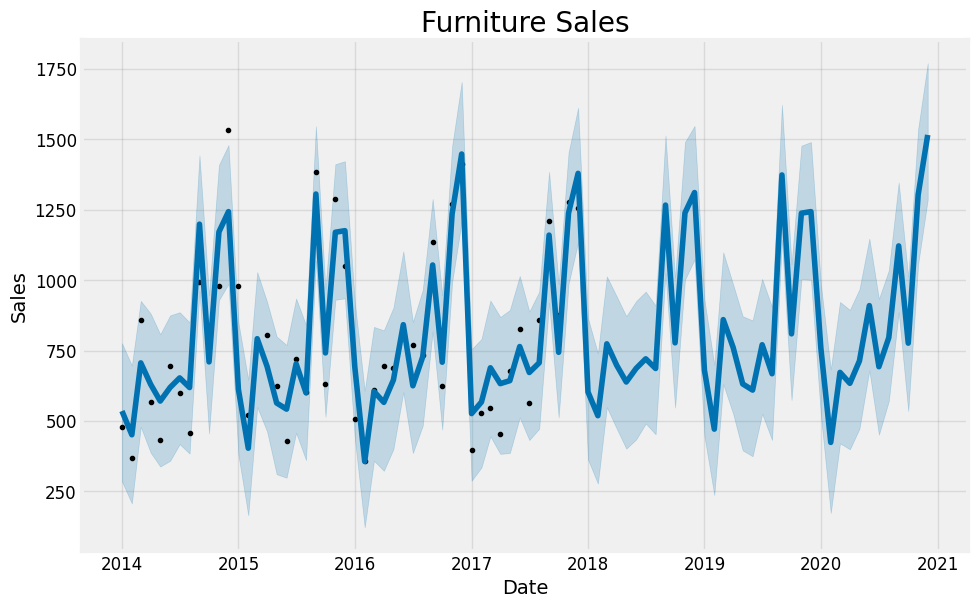

In [118]:
plt.figure(figsize = (15, 10))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales')

Text(0.5, 1.0, 'Office Supplies Sales')

<Figure size 1500x1000 with 0 Axes>

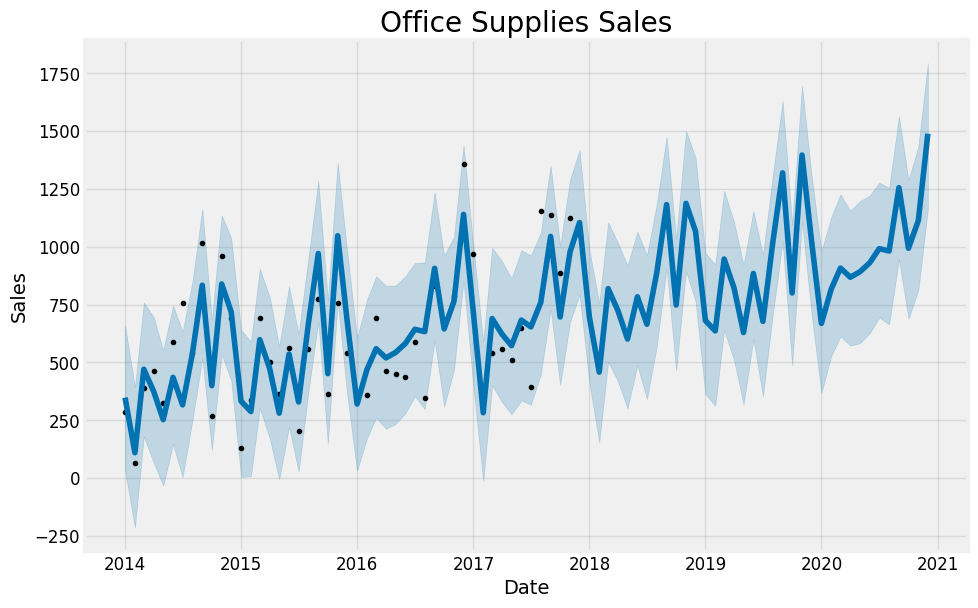

In [119]:
plt.figure(figsize = (15, 10))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales')

In [120]:
# Compare Future Forecasts
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

In [121]:
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

In [122]:
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

In [127]:
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

In [128]:
forecast = forecast.rename(columns = {'furniture_ds': 'Date'}).drop('office_ds', axis = 1)
forecast.head(3)

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.058109,284.981363,776.222185,726.058109,726.058109,-190.686099,-190.686099,-190.686099,-190.686099,...,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,-140.041115,0.0,0.0,0.0,347.489370
1,2014-02-01,727.494421,207.330548,697.338704,727.494421,727.494421,-276.379157,-276.379157,-276.379157,-276.379157,...,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,-385.677761,0.0,0.0,0.0,109.240405
2,2014-03-01,728.791734,479.274602,926.594451,728.791734,728.791734,-22.388253,-22.388253,-22.388253,-22.388253,...,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,-31.378526,0.0,0.0,0.0,470.212385


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Furniture vs. Office Supplies Sales Trend')

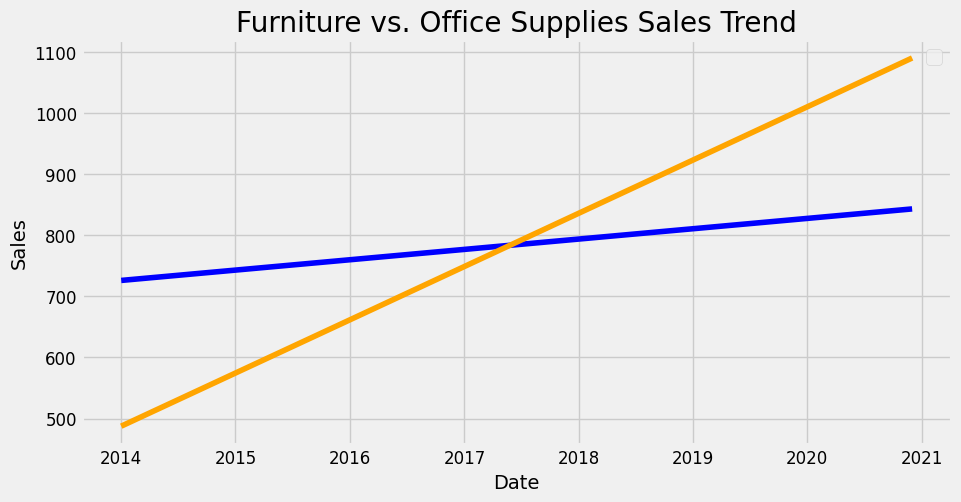

In [129]:
# Trend and Forecast Visualization
plt.figure(figsize = (10, 5))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Furniture vs. Office Supplies Estimate')

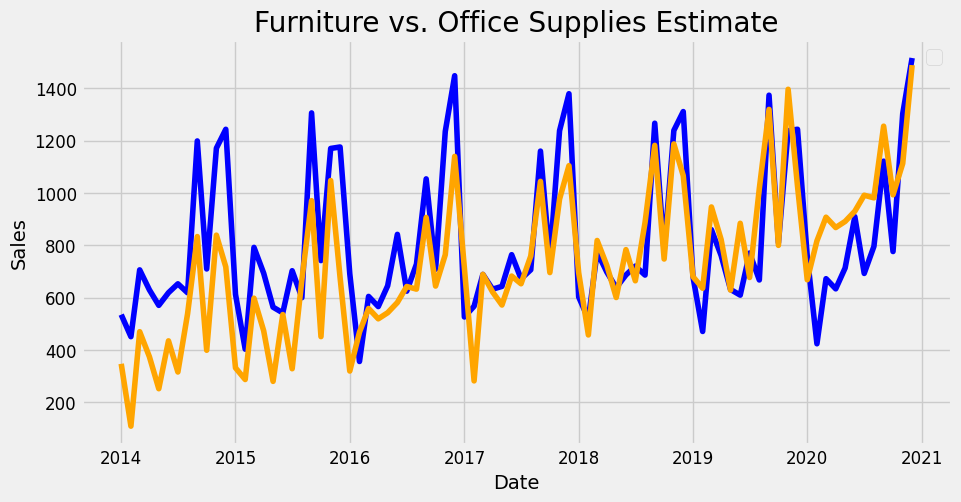

In [130]:
plt.figure(figsize = (10, 5))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'orange')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate')

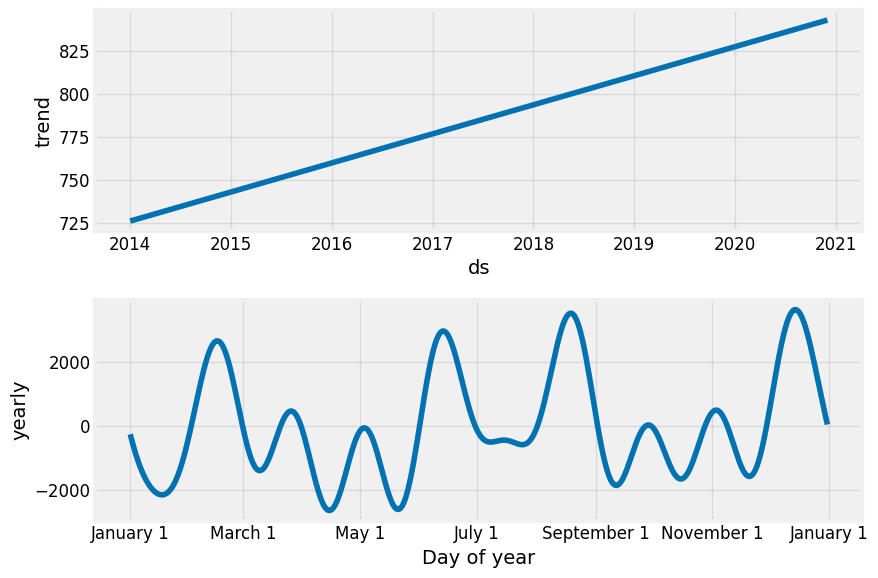

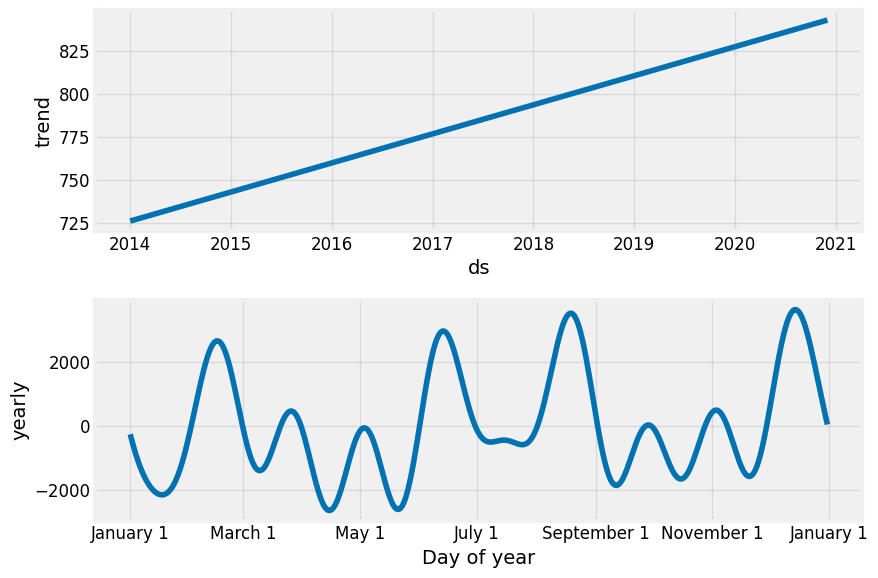

In [132]:
# Trends and Patterns
furniture_model.plot_components(furniture_forecast)

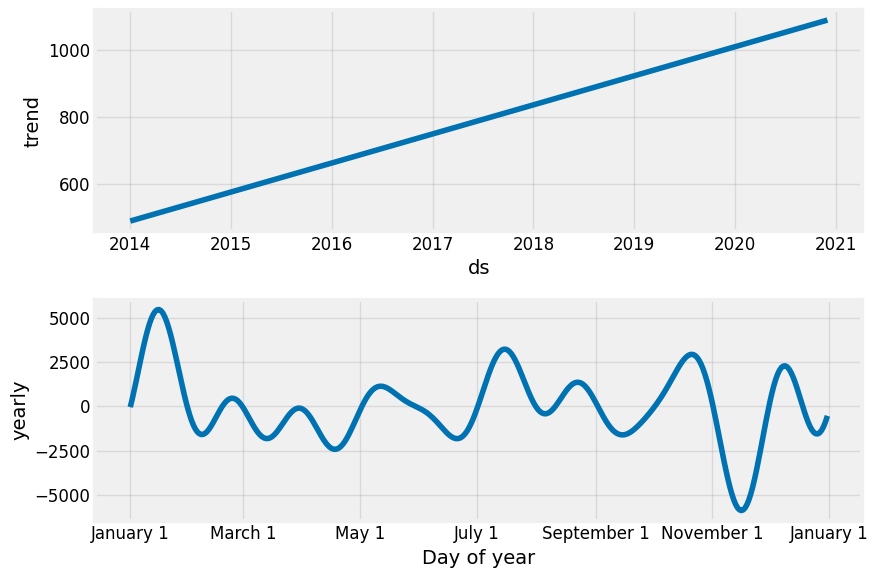

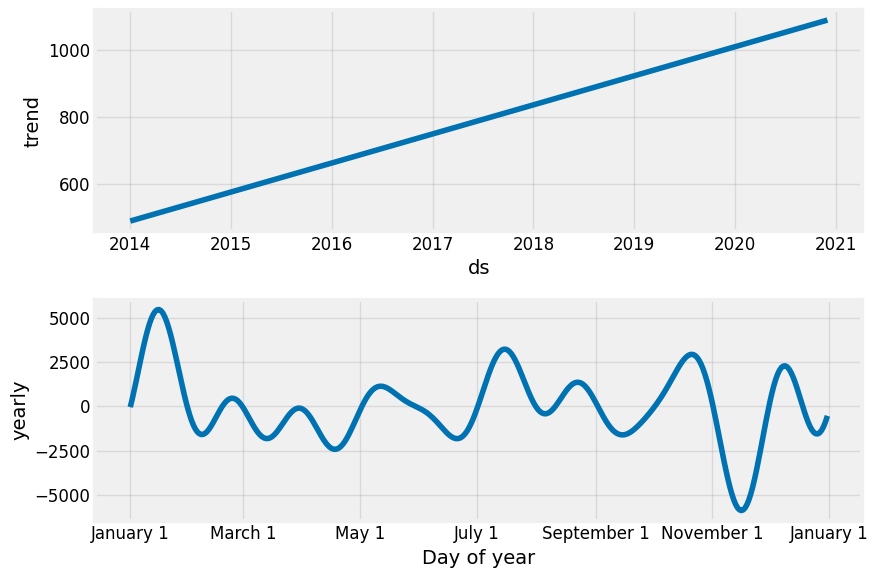

In [133]:
office_model.plot_components(office_forecast)